In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

country_summary = pd.read_csv('countries.csv')
user_summary = pd.read_csv('age_gender_bkts.csv')

Populating the interactive namespace from numpy and matplotlib


# Data Examination

## Country Summary Statistics

Lets begin by examining our summary statistic table for the countries of travel.

In [2]:
country_summary

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


We can see below that we are working with 9 different countires, their locations, and some other statitics. With some quick research, we find the definitions of the country and language codes. Lets append these values to our table. 

In [3]:
country_summary['countries'] = ['Australia', 'Canada', 'Germany', 'Spain', 'France', 
                                     'United Kingdom', 'Italy', 'Netherlands', 'Portugal', 'United States']
country_summary['languages'] = ['English', 'English', 'German', 'Spanish', 'French', 
                                'English', 'Italian', 'Dutch', 'Portuguese', 'English']

With a little additional research, the distance_km column indicates the (summary, preasumably mean) distance between the United States and the country in each row. We can see that the distance_km for US is 0. Additionally, there is a column destination_km2, which appears to be distances to the destination squared. We can tell by the massive distances, the Earth has a circumference of about 40,000 km for reference. Lets adjust. Since we have these values, we can also remove longitude and latitude information. 

In [4]:
country_summary['destination_dst'] = np.sqrt(country_summary['destination_km2'])
del country_summary["destination_km2"] 
del country_summary["lat_destination"]
del country_summary["lng_destination"]
country_summary

,country_destination,distance_km,destination_language,language_levenshtein_distance,countries,languages,destination_dst
0,AU,15297.7440,eng,0.00,Australia,English,2782.304800
1,CA,2828.1333,eng,0.00,Canada,English,3159.852845
2,DE,7879.5680,deu,72.61,Germany,German,597.513180
3,ES,7730.7240,spa,92.25,Spain,Spanish,710.893804
4,FR,7682.9450,fra,92.06,France,French,802.372108
5,GB,6883.6590,eng,0.00,United Kingdom,English,493.568638
6,IT,8636.6310,ita,89.40,Italy,Italian,548.944442
7,NL,7524.3203,nld,63.22,Netherlands,Dutch,203.821000
8,PT,7355.2534,por,95.45,Portugal,Portuguese,303.463342
9,US,0.0000,eng,0.00,United States,English,3134.752781


After adjusting the distances using the numpy sqrt function, we can see that the 'destination_km'apperas to be the distance from the country to the actual AirBnb destinations. This could possibly be used as an approximate statistic for how far travelers have to go after reaching that country. We see that travelers who stay within the US or go to Canada have to travel the further to their destination upon reching the country, while travelers going to the smaller European countries consistently travel less than 1000 km upon reaching the country.

Finally, lets look at the column language_levenshtein_distance. As one might guess, the Levenshtein distance is a metric used to guage the differences in the language by measuring the number of single character edits used to change a word into another. Now while we don't know the exact computation of the Levenshtein distances in the table, we can use it as a quantifiable difference between English and the language of the destination country (assuming that language is not English). We can see that of the non-English speaking destinations, Dutch is the most similar and Portuguese is the most different. 

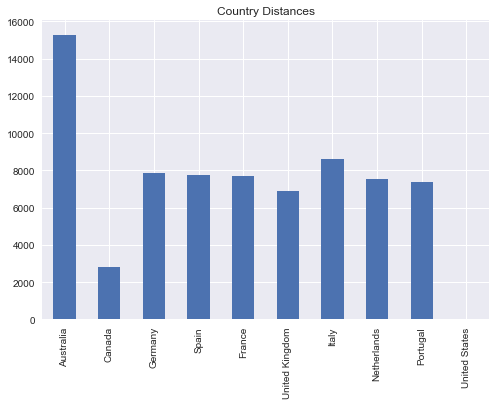

In [5]:
ax = plt.axes()
dest = country_summary['distance_km'].plot(kind='bar', ax=ax)
dest.set_xticklabels(country_summary['countries'])
ax.set_title('Country Distances')

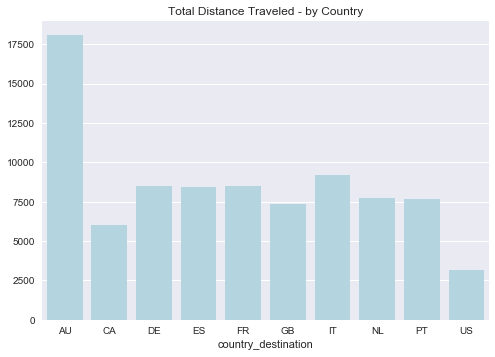

In [6]:
ax = plt.axes()
sns.barplot(x=country_summary['country_destination'], 
            y=country_summary['destination_dst']+country_summary['distance_km'],
            color="lightblue", ax=ax)
ax.set_title('Total Distance Traveled - by Country')

In [7]:
country_summary["Total Distance Traveled"] = country_summary['destination_dst']+country_summary['distance_km']

# User Summary Statistics

Next lets take a look at our user summary statistics. We see we have age bucket, country of destination, gender, population in thousands, and year. 

In [8]:
len(user_summary)

420

In [9]:
user_summary.columns

Index(['age_bucket', 'country_destination', 'gender',
       'population_in_thousands', 'year'],
      dtype='object')

In [10]:
user_summary.head(2)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0


In [11]:
user_summary.groupby('country_destination').sum().sort_values('population_in_thousands').drop(['year'], axis=1)

,population_in_thousands
country_destination,
PT,10609.0
NL,16848.0
AU,23923.0
CA,35871.0
ES,47203.0
IT,61145.0
GB,63840.0
FR,64983.0
DE,82562.0


We can see all of our data is from 2015. Out of our data set the most frequently visited country is the United States (not surprisingly) followed by Germany and the least is Portugal, followed by the Netherlands. 

In [12]:
user_summary.groupby(['age_bucket', 'gender']).sum().sort_values('population_in_thousands').drop(['year'], axis=1)

population_in_thousands
age_bucket gender                         
100+       male                       30.0
           female                    145.0
95-99      male                      254.0
           female                    829.0
90-94      male                     1439.0
           female                   3512.0
85-89      male                     3912.0
80-84      male                     6995.0
85-89      female                   7050.0
80-84      female                  10086.0
75-79      male                    10515.0
           female                  13189.0
70-74      male                    13601.0
           female                  15685.0
65-69      male                    18187.0
           female                  20009.0
10-14      female                  20640.0
5-9        female                  20753.0
0-4        female                  20861.0
60-64      male                    20921.0
15-19      female                  21177.0
10-14      male                    21604.0
5-9        male                    21724.0
0-4        male                    21925.0
15-19      male                    22170.0
20-24      female                  22504.0
60-64      female                  22506.0
25-29      female                  23434.0
35-39      female                  23527.0
20-24      male                    23579.0
35-39      male                    23727.0
55-59      male                    23916.0
30-34      female                  23993.0
25-29      male                    24287.0
30-34      male                    24415.0
40-44      male                    24582.0
           female                  24588.0
55-59      female                  24966.0
45-49      male                    25905.0
           female                  25959.0
50-54      male                    26221.0
           female                  26794.0

An examination of our user summary statistics reveals that we are working with a wide age group - from infants to the elderly. We have these age buckets split by gender and country destination. We also have the population of visitors, in thousands. There are 21 age buckets with 20 rows in each. It is interesting to note that the ages 40-60 showed the highest number of travelers, while ages over 60 showed the lowest number of travelers. These two summary data sets will be useful for exploratory data analysis. 

# Main User Data

In [13]:
users = pd.read_csv('train_users_2.csv')
sessions = pd.read_csv('sessions.csv')

Lets take a look at our train data set. We have 213451 entries, with 16 columns. 

In [14]:
len(users.columns),len(users)

(16, 213451)

In [15]:
users.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [16]:
del users['timestamp_first_active']
users.head()

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


We have unique identifier, the date of account creation, and the timestamp of activation. Since we already have the date of account creation, we do not need to first active time. We also have the date of the first booking, gender, age and signup method. Signup flow is the page a user came to sign up from. We have language, their international language preference. We also have Affiliate data and date about each user's first signup. Finally, we have their first destination country.

Lets take a look at the Sessions data. We may not need this data set at all. For the analysis, lets focus on the user data clean up and we can join the sessions data set to the users on the ID column if necessary. 

In [17]:
len(sessions.columns),len(sessions)

(6, 10567737)

In [18]:
sessions.tail()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221.0


## Join other data to this table

In [19]:
sessions['id'] = sessions ['user_id']
del sessions['user_id']
full_user = pd.merge(users, sessions, how='left', on='id')


In [20]:
full_user.tail()

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail,device_type,secs_elapsed
5677588,nw9fwlyb5f,2014-06-30,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,index,data,reservations,iPhone,245.0
5677589,nw9fwlyb5f,2014-06-30,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,unavailabilities,data,unavailable_dates,iPhone,286.0
5677590,nw9fwlyb5f,2014-06-30,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,notifications,submit,notifications,iPhone,830.0
5677591,nw9fwlyb5f,2014-06-30,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,search,click,view_search_results,iPhone,101961.0
5677592,nw9fwlyb5f,2014-06-30,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,search,click,view_search_results,iPhone,10863.0


In [21]:
users['age'].value_counts().sort_index().head()

1.0      2
2.0      7
4.0      3
5.0     45
15.0     8
Name: age, dtype: int64

In [22]:
#Lets view the distribution of ages between 13 and 90, assuming these are 'real'
users_age = users[(users['age']>13)&(users['age']<90)]

In [23]:
age = users_age['age']
age = age.dropna(how='all')

## Age Distribution

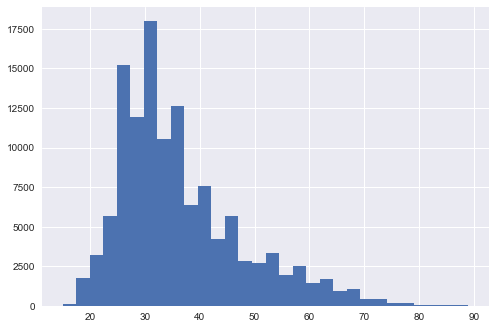

In [24]:
age.hist(bins=30)

Lets take a look at the gender column next. Unfortunately we see that a 44 percentage of the data is unknown. The distribution of user gender over male, female, and other is shown below. 

In [25]:
gender=users['gender']
gender.value_counts() 

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [26]:
#Percent Unknown
len(gender[gender=='-unknown-'])/len(gender)

0.44829023991454714

## Gender Distribution

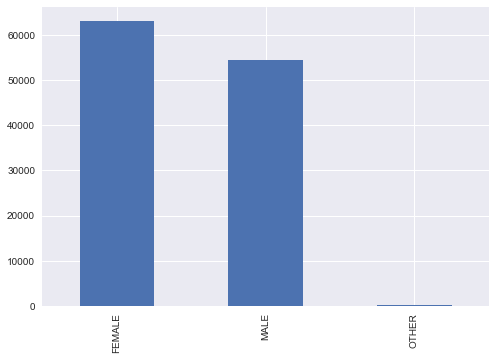

In [27]:
gender_known = gender[gender!='-unknown-']
gender_known = gender_known.dropna(how='all')
gender_known.value_counts().plot(kind='bar')



## Country of destination

In [28]:
dest = users['country_destination'].dropna(how='any')
dest.value_counts('NDF')

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

Interesting. Over half of the user sign ups did not end up booking a destination, and about 41% do. Not surprisingly, most first bookings by Americans occur domestically. Next, lets look at the distribution of actual first bookings (no NDF values or US values).

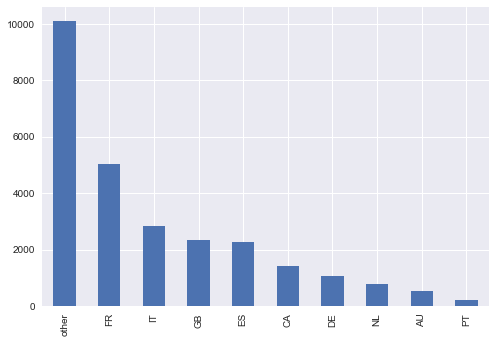

In [29]:
dest_booked = dest[(dest!='NDF')&(dest!='US')]
dest_booked.value_counts().plot(kind='bar')

## International Language Preference

Lets contrast this with the distribution of the international language preferences.

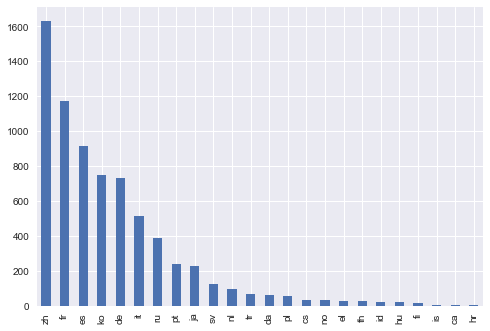

In [30]:
languages = users['language'].dropna(how='any')
languages.value_counts()
languages_foreign = languages[languages!='en']
languages_foreign.value_counts().plot(kind='bar')

Note: Zh is chinese, and Ko is Korean. It appears that the 'Other' bookings would contain several bookings in China or Hong Kong and Korea. 

## Signup Method 

Lets take a look at the methods of first access. We see that most people accessed AirBnb directly, through a website. It might be interesting to investigate this further by categorizing our data by age groups. 

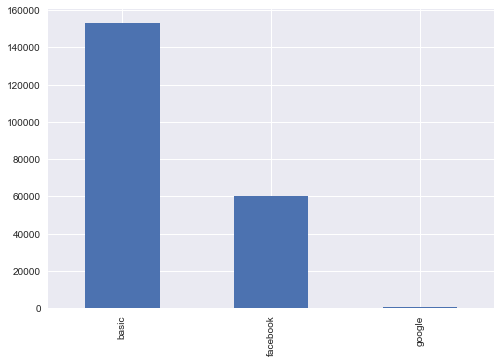

In [31]:
users['signup_method'].value_counts().plot(kind='bar')

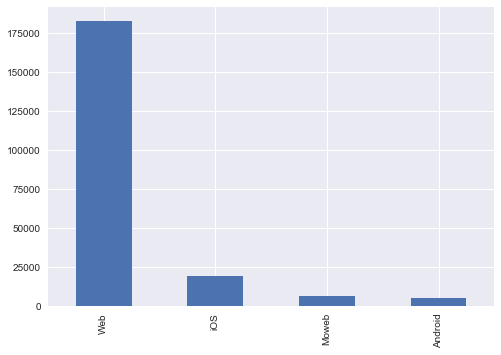

In [32]:
users['signup_app'].value_counts().plot(kind='bar')

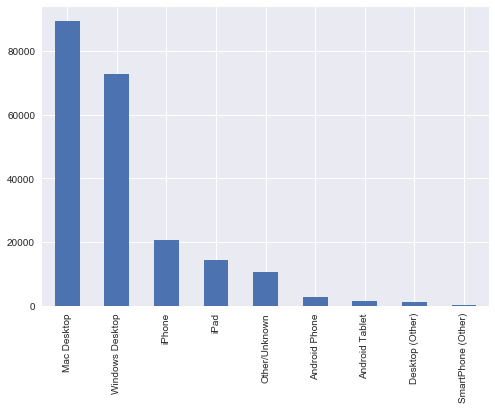

In [33]:
users['first_device_type'].value_counts().plot(kind='bar')

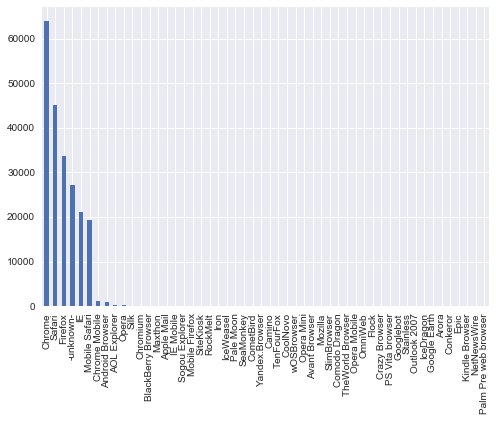

In [34]:
users['first_browser'].value_counts().plot(kind='bar')

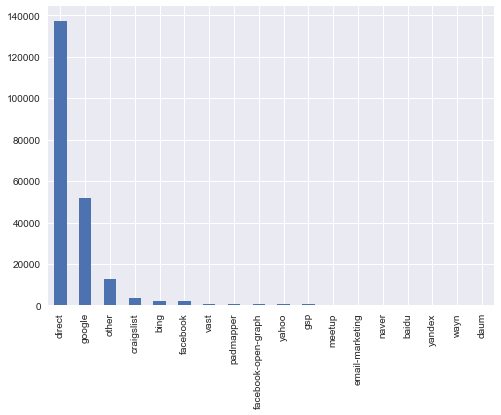

In [35]:
users['affiliate_provider'].value_counts().plot(kind='bar')

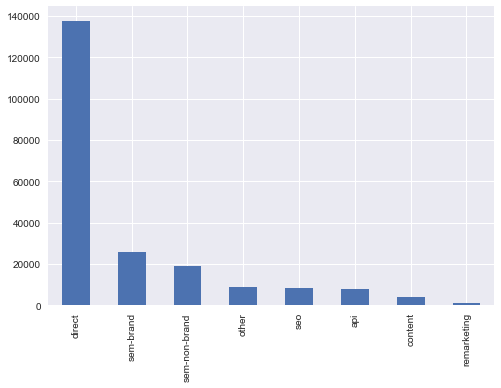

In [36]:
users['affiliate_channel'].value_counts().plot(kind='bar')

# Data Cleanup

## Explore NAs and Outliers, Quantify missing data. Play with imputation.

In [37]:
users['gender'].unique()
users['gender']=users['gender'].replace('-unknown-', np.nan)

In [38]:
users.isnull().sum()

id                              0
date_account_created            0
date_first_booking         124543
gender                      95688
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

We don't have reason to believe that a significant number of users would have lied about their gender, because it was an optional value (indicated by the 96,000 missing values) and "other" was also an option. However, we know that our age data is off. AirBnB users must be over the age of 18 to sign up, yet our age distribution indicates otherwise. Additionally, although it is possible for elderly users (90+) to use AirBnB, we saw earlier that this group is a minority in terms of travelers. Lets ignore these values, (which will also weed out fake ages, like 112). Before we do that, we make sure to convert people who accidentally used their birth year instead of their age.

In [39]:
#Convert dates to useable formats
users['date_account_created'] = users['date_account_created'].apply(lambda x: pd.tslib.Timestamp(x))
users['date_first_booking'] = users['date_first_booking'].apply(lambda x: pd.tslib.Timestamp(x))

In [40]:
users['created_year'] = users['date_account_created'].apply(lambda x: x.year)
users

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,created_year
0,gxn3p5htnn,2010-06-28,NaT,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010
1,820tgsjxq7,2011-05-25,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011
4,87mebub9p4,2010-09-14,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010
5,osr2jwljor,2010-01-01,2010-01-02,NaN,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010
6,lsw9q7uk0j,2010-01-02,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010
7,0d01nltbrs,2010-01-03,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,2010
8,a1vcnhxeij,2010-01-04,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010
9,6uh8zyj2gn,2010-01-04,2010-01-04,NaN,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US,2010


In [51]:
users["age"] = users.apply(lambda r: (r["created_year"] - r["age"]) if r["age"] > 1000 else r["age"], axis=1)

In [61]:
# Remove outliers that we consider 'fake'
users['age'] = users['age'].apply(lambda x: np.nan if x>90 else x)
users['age'] = users['age'].apply(lambda x: np.nan if x<18 else x)

## Adding calculated columnns - Age Group, Language, Levenshtein Distance, Month 

Lets start by adding Age Group. We will use the following age groups: GI Generation (born <= 1924), Silent Generation(1925-1942), Baby Boomers (1943-1960), Generation X (1961-1980), and the Millenials (1981-1996)

In [63]:
users['birthYear'] = users['created_year']-users['age']

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,created_year,birthYear
0,gxn3p5htnn,2010-06-28,NaT,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,NaN
1,820tgsjxq7,2011-05-25,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,1973.0
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,1954.0
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,1969.0
4,87mebub9p4,2010-09-14,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,1969.0
5,osr2jwljor,2010-01-01,2010-01-02,NaN,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010,NaN
6,lsw9q7uk0j,2010-01-02,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1964.0
7,0d01nltbrs,2010-01-03,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,2010,1963.0
8,a1vcnhxeij,2010-01-04,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1960.0
9,6uh8zyj2gn,2010-01-04,2010-01-04,NaN,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US,2010,1964.0


In [99]:
users['ageGroup'] = np.nan
users['ageGroup'][users['birthYear'] <= 1996] = "Millenial"
users['ageGroup'][users['birthYear'] <= 1980] = "Generation X"
users['ageGroup'][users['birthYear'] <= 1960] = "Baby Boomers"
users['ageGroup'][users['birthYear'] <= 1942] = "Silent Generation"
users['ageGroup'][users['birthYear'] <= 1924] = "GI Generation"


C:\Users\amungale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\amungale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\amungale\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\U

In [100]:
users

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,created_year,birthYear,ageGroup
0,gxn3p5htnn,2010-06-28,NaT,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,NaN,NaN
1,820tgsjxq7,2011-05-25,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,1973.0,Generation X
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,1954.0,Baby Boomers
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,1969.0,Generation X
4,87mebub9p4,2010-09-14,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,1969.0,Generation X
5,osr2jwljor,2010-01-01,2010-01-02,NaN,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010,NaN,NaN
6,lsw9q7uk0j,2010-01-02,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1964.0,Generation X
7,0d01nltbrs,2010-01-03,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,2010,1963.0,Generation X
8,a1vcnhxeij,2010-01-04,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1960.0,Baby Boomers
9,6uh8zyj2gn,2010-01-04,2010-01-04,NaN,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US,2010,1964.0,Generation X


In [102]:
# Add destination_language and language_levenshtein_distance
country_summary

,country_destination,distance_km,destination_language,language_levenshtein_distance,countries,languages,destination_dst,Total Distance Traveled
0,AU,15297.7440,eng,0.00,Australia,English,2782.304800,18080.048800
1,CA,2828.1333,eng,0.00,Canada,English,3159.852845,5987.986145
2,DE,7879.5680,deu,72.61,Germany,German,597.513180,8477.081180
3,ES,7730.7240,spa,92.25,Spain,Spanish,710.893804,8441.617804
4,FR,7682.9450,fra,92.06,France,French,802.372108,8485.317108
5,GB,6883.6590,eng,0.00,United Kingdom,English,493.568638,7377.227638
6,IT,8636.6310,ita,89.40,Italy,Italian,548.944442,9185.575442
7,NL,7524.3203,nld,63.22,Netherlands,Dutch,203.821000,7728.141300
8,PT,7355.2534,por,95.45,Portugal,Portuguese,303.463342,7658.716742
9,US,0.0000,eng,0.00,United States,English,3134.752781,3134.752781


In [118]:
lang_summary = country_summary[['country_destination', 'destination_language ', 'language_levenshtein_distance']]
add_language = pd.merge(users, lang_summary, how='left', on='country_destination')

In [122]:
add_language.head()

,id,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,created_year,birthYear,ageGroup,destination_language,language_levenshtein_distance
0,gxn3p5htnn,2010-06-28,NaT,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,1973.0,Generation X,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,1954.0,Baby Boomers,eng,0.0
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,1969.0,Generation X,NaN,NaN
4,87mebub9p4,2010-09-14,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,1969.0,Generation X,eng,0.0


# Relationships between Variables

## Pairs Plot

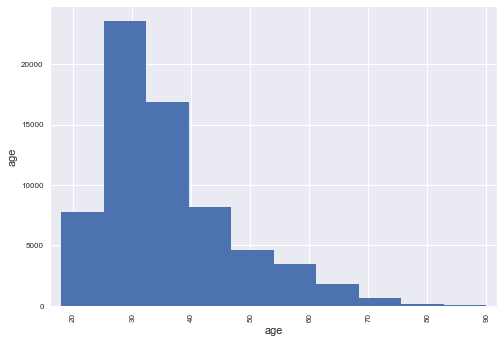

In [129]:
pairs_data = add_language[['date_account_created', 'date_first_booking', 'age']]
pairs_data = pairs_data.dropna()
axes = pd.tools.plotting.scatter_matrix(pairs_data, alpha=0.2)

### What proportion of users actually booked a destination? Time between account creation and first booking? 

### How do language preferences compare to actual bookings?

### What booking tendancies for travel destinations can you observe by group? Are there differences between the age groups? The genders? Do certain methods of sign up lead to higher booking rates?

### Do Americans prefer to travel to to English speaking countries? Are there differences between the age groups? The genders? Signup method?

### Is there a seasonal impact (does the time year affect the country booked)?

### How does the distribution of AirBNB travel destinations vary from the population (compare number traveled to each country to summary statistics for population traveled to each country)

# Overall Outline

## Introduction to Problem

## Examine and Clean Data

## Explore NAs, Quantify missing data. Play with imputation.

## Summary statistics for Categorical Variables

## Summary Statistics for Continuous Variables 

## Univariate Exploration

## Bivariate / Multivariate Exploration

## Heat map for relationships between categorical variables

## Fit a logistic / multi class regression model to the data. 